## This notebook analyzes associations between phenotypes, DNA features, and gene embeddings.

In [1]:
import os
os.environ['SPECIES'] = "Mouse"
from eval.visual_utils import (get_naming_dict, filter_dataframe, FigureStyle, pval2stars, Naming_Json, export_to_excel)
njson = Naming_Json()
exp = njson.exp
exp_short = exp.split("_")[0]
m_param_json_file = f"/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/{exp_short}/{exp}.param_config.json"
os.environ['PARAM_JSON_FILE'] = m_param_json_file

from utils.utils import get_device, get_model, get_config
from train.common_params_funs import get_gene2idx
from utils.params import params
from eval.eval_utils import get_self_emb
from sklearn.metrics.pairwise import cosine_similarity
from eval_m.m_eval_utils import get_n_closest_tokens, reorder_symmetric_matrix, mean_and_std_of_arrays, find_rank_of_similarity, get_similarity, n_closest_tokens_to_gene_pair_list
from eval_m.m_visual_utils import density_colored_scatter, plot_PCA, plot_histogram, plot_comparison_box, plot_custom_ecdf, plot_comparison_bar_with_ci, plot_side_by_side_histogram
from data_m.get_homolo_mg import get_homolo_mg
from data_m.m_data_utils import split_human_mouse_emb_and_genes, split_dict, dict_to_file, write_string_to_file, save_matrix_and_ids, load_matrix_and_ids
from data_m.m_data_utils import read_gz_tsv, print_unique_values, df_cols_to_dict, query_genes, get_combined_dna_seq_conserv_df, add_anno_info
from dna.dna_utils import file_to_dict
import numpy as np
from data.data_utils import output_emb
from eval_m.muse_utils import load_muse_result, get_gene_to_ori_case_dict, get_muse_result_uid_dir
import glob
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import textwrap
import matplotlib.gridspec as gridspec
from scipy import stats
from eval.visual_utils import pval2stars
import re

params = params()
config = get_config()


Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Run in training mode!
param_json_file is /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/anal_mouse/training/exp6/exp6_hm_GPT_coding.param_config.json
Parameter of params.SPECIFIED_PRETRAIN_MODEL_CHECKPOINT_PATH not found in the input json file, use default value of None!
/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/results/models/pretrain/exp9/model.rank0.
None


/home/561/zs2131/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse


In [2]:
njson = Naming_Json()
epoch = njson.epoch
exp = njson.exp
# Flag to indicate whether the average similarity matrix should be directly loaded.
directly_load_average_simi_matrix = True

# Flag to indicate whether separated similarity matrices should be directly loaded.
directly_load_separated_simi_matrices = True

# Flag to control the output of the N closest tokens based on similarity matrix calculations.
# If False, this operation will be skipped.
output_n_closest_tokens_if_not_directly_load_simi_mat = False

# Define the path to the output file where the similarity matrix will be saved.
similarity_matrix_output_file = f"{config.proj_path}//results/data_avail/similarity_matrix.npy"

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse


In [3]:
# Check if the program should directly load pre-computed similarity matrices.
if directly_load_separated_simi_matrices:
    # Define the path to load the shared embedding and supervised alignment similarity matrix.
    input_file = f"{config.proj_path}/results/anal/gpt_merged/reordered_simi_muse_mean.muse.epoch{epoch}.npy"
    # Load the similarity matrix and associated gene names from the file.
    gpt_merged_muse_simi_mat_ori, gpt_merged_muse_gene_names_ori = load_matrix_and_ids(input_file)
    # Determine the token types (mouse or human) based on gene prefixes in the gene names.
    gpt_merged_muse_token_types = [njson.m_label if config.gene_prefix in gene else njson.h_label for gene in gpt_merged_muse_gene_names_ori]

    # if output_n_closest_tokens_if_not_directly_load_simi_mat:
    #     n_closest_tokens = get_n_closest_tokens(gpt_merged_muse_simi_mat_ori, 
    #                          gpt_merged_muse_gene_names_ori,
    #                          gpt_merged_muse_token_types,
    #                          output_file=f"{input_file}.anal.{njson.n_closest}_closest.txt",
    #                          n_closest=njson.n_closest
    #                         )
    #     
    
    # Load and prepare supervised alignment similarity matrix for further analysis.
    dir_without_uid = f"{config.proj_path}/results/anal/{exp}/{exp}.epoch{epoch}.full_supervised"
    muse_result_uid_dir = get_muse_result_uid_dir(dir_without_uid)
    gene2idx, _ = get_gene2idx(params.GENE_EMB_NAME)
    gene_to_ori_case_dict = get_gene_to_ori_case_dict(gene2idx)
    muse_result_dir = get_muse_result_uid_dir(dir_without_uid)
    # Load embeddings, gene names, and token types from MUSE result directory.
    hm_emb, hm_gene_names, hm_token_types = load_muse_result(muse_result_dir, gene_to_ori_case_dict=gene_to_ori_case_dict)
    # Calculate the supervised alignment similarity matrix using cosine similarity.
    supv_similarity_matrix = cosine_similarity(hm_emb)

    # Filter out special embeddings and prepare data for output.
    idx_of_non_special_emb = [i for i, gene in enumerate(hm_gene_names) if "special_emb" not in gene.lower()]
    hm_emb_non_special_emb = hm_emb[idx_of_non_special_emb]
    hm_gene_names_non_special_emb = np.array(hm_gene_names)[idx_of_non_special_emb]
    # Output the filtered embeddings to a file.
    output_emb(
        hm_gene_names_non_special_emb,
        hm_emb_non_special_emb,
        output_file_path=f"{config.proj_path}//results/data_avail/Human_mouse_coding_gene_embeddings_supervised_aligned.txt",
        write_emb_dim_to_first_line=True,
    )

    # if output_n_closest_tokens_if_not_directly_load_simi_mat:
    #     n_closest_tokens = get_n_closest_tokens(supv_similarity_matrix, 
    #                      hm_gene_names,
    #                      hm_token_types,
    #                      output_file=f"{dir_without_uid}/closest_tokens.{njson.n_closest}_closest.txt",
    #                      n_closest=njson.n_closest
    #                     )
    #     
    
# If not directly loading the average similarity matrix, proceed with calculations.
if directly_load_average_simi_matrix == False:    
    # Reorder the similarity matrix to match gene names and calculate the averaged matrix.
    gpt_merged_muse_simi_mat = reorder_symmetric_matrix(gpt_merged_muse_simi_mat_ori, gpt_merged_muse_gene_names_ori, hm_gene_names)
    averaged_align_and_shared_emb_align_simi_mat = (supv_similarity_matrix + gpt_merged_muse_simi_mat)/2.0
    # Save the averaged similarity matrix and associated gene names.
    save_matrix_and_ids(averaged_align_and_shared_emb_align_simi_mat, 
                    hm_gene_names,
                    similarity_matrix_output_file)
    # Optionally, output the closest gene pairs based on the averaged similarity matrix.
    if output_n_closest_tokens_if_not_directly_load_simi_mat:
        n_closest_tokens = get_n_closest_tokens(averaged_align_and_shared_emb_align_simi_mat, 
                 hm_gene_names,
                 hm_token_types,
                 output_file=f"{config.proj_path}//results/data_avail/closest_{njson.n_closest}.coding_genes.txt",
                 n_closest=njson.n_closest
                )
        # Save the closest gene pairs to a file for further analysis.
        file_path = f"{config.proj_path}/results/anal/ave_supAlign_and_sharedEmbSupAlign/closest_genes.{njson.n_closest}_closest.pkl"
        with open(file_path, 'wb') as file:
            pickle.dump(n_closest_tokens, file)

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Reading gene_to_idx_path /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/data/embedding/hm_coding_gene_to_idx.json!
Loaded emb from file_path!
Loaded emb from file_path!
Saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse///results/data_avail/Human_mouse_coding_gene_embeddings_supervised_aligned.txt


In [4]:
human_genes = [gene for gene in gene2idx if "special_emb" not in gene.lower() and config.gene_prefix not in gene]
mouse_genes = [gene for gene in gene2idx if "special_emb" not in gene.lower() and config.gene_prefix in gene]
print(len(human_genes))
print(len(mouse_genes))

18757
19163


In [5]:
if directly_load_average_simi_matrix:
    averaged_align_and_shared_emb_align_simi_mat, hm_gene_names = load_matrix_and_ids(similarity_matrix_output_file)
    hm_token_types = [njson.m_label if config.gene_prefix in gene else njson.h_label for gene in hm_gene_names]
    file_path = f"{config.proj_path}/results/anal/ave_supAlign_and_sharedEmbSupAlign/closest_genes.{njson.n_closest}_closest.pkl"
    with open(file_path, 'rb') as file:
        n_closest_tokens = pickle.load(file)

In [6]:
averaged_align_and_shared_emb_align_simi_mat.shape

(37926, 37926)

In [7]:
def get_simi_and_anno_for_df(dna_cons_df_combined, simi_mat, gene_names, config, njson, add_anno_info_to_df=True):
    """
    Augments a DataFrame with similarity rankings and optionally annotation information based on gene pair comparisons.

    Parameters:
    - dna_cons_df_combined: DataFrame containing gene pairs. Only the 'gene_pair' column is required.
    - simi_mat: A similarity matrix where each entry represents the similarity between two genes.
    - gene_names: A list of gene names corresponding to the indices in the similarity matrix.
    - config: Configuration object containing settings and parameters for the operation.
    - njson: An object containing naming conventions and other constants used in the analysis.
    - add_anno_info_to_df: Boolean flag indicating whether additional annotation information should be added to the DataFrame.
    """
    
    # If the 'h_gene' and 'm_gene' columns are not in the DataFrame, extract them from the 'gene_pair' column.
    if 'h_gene' not in dna_cons_df_combined.columns:
        dna_cons_df_combined[['h_gene', 'm_gene']] = dna_cons_df_combined['gene_pair'].str.split(' ', expand=True)
    
    # Determine the type of each gene based on its prefix and store the types in a list.
    gene_types = [njson.m_label if config.gene_prefix in gene else njson.h_label for gene in gene_names]
    # Ensure the number of gene names matches the size of the similarity matrix.
    assert len(gene_names) == simi_mat.shape[0]

    # Create a list of tuples representing human-mouse gene pairs from the DataFrame.
    list_of_hm_gene_tuples = list(zip(dna_cons_df_combined['h_gene'], dna_cons_df_combined['m_gene']))
    # Find and store the similarity ranks for each human-mouse gene pair.
    _, ranks_gene_pair_as_key_for_df = find_rank_of_similarity(simi_mat, gene_names, list_of_hm_gene_tuples, gene_types)
    dna_cons_df_combined['hm_simi_rank'] = list(ranks_gene_pair_as_key_for_df.values())
    
    # Create a list of tuples representing mouse-human gene pairs from the DataFrame.
    list_of_mh_gene_tuples = list(zip(dna_cons_df_combined['m_gene'], dna_cons_df_combined['h_gene']))
    # Find and store the similarity ranks for each mouse-human gene pair.
    _, ranks_gene_pair_as_key_for_df = find_rank_of_similarity(simi_mat, gene_names, list_of_mh_gene_tuples, gene_types)
    dna_cons_df_combined['mh_simi_rank'] = list(ranks_gene_pair_as_key_for_df.values())
    
    # Create a dictionary mapping gene names to their indices in the similarity matrix.
    id2idx = {name: idx for idx, name in enumerate(gene_names)}
    # Calculate and store the mean embedding similarity for each gene pair in the DataFrame.
    dna_cons_df_combined['mean_emb_similarity'] = dna_cons_df_combined.apply(
        lambda row: get_similarity(row['h_gene'], row['m_gene'], simi_mat, id2idx), axis=1)
    
    # If requested, add additional annotation information to the DataFrame and return it.
    if add_anno_info_to_df:
        dna_cons_df_combined_expanded = add_anno_info(dna_cons_df_combined, config)
        return dna_cons_df_combined_expanded
    else:
        # Otherwise, return the DataFrame with similarity information only.
        return dna_cons_df_combined
    

In [8]:
def get_df_complete_list_of_gene_pairs_three_types(n_closest_tokens, config):
    """
    Compiles a DataFrame containing lists of gene pairs categorized into homologs and random non-homologs,
    excluding those identified as closest non-homologs based on n_closest_tokens analysis.

    Parameters:
    - n_closest_tokens: A dictionary or list detailing the closest tokens (gene pairs) based on similarity analysis.
    - config: A configuration object containing settings, such as file paths and project details.
    """

    # Retrieve homolog gene pairs from a predefined function.
    # This includes both human-to-mouse and mouse-to-human mappings, as well as one-to-one mappings.
    h2m_genes, m2h_genes, h2m_one2one, m2h_one2one = get_homolo_mg()
    # Format the human-to-mouse gene pairs for inclusion in the DataFrame.
    h2m_genes_gene_pairs = [f"{k} {gene}" for k, v in h2m_genes.items() for gene in v]

    # Load a predefined list of random gene pairs from a file.
    random_gene_pair_file = f"{config.proj_path}/results/anal/dna/random_gene_pairs/random_gene_pairs_not_have_close_emb_non_homolog.exp16_hm_BERT_coding.seed8.txt"
    with open(random_gene_pair_file, 'r') as file:
        random_gene_pairs = file.read().splitlines()

    # Convert closest tokens to gene pair format and filter out pairs that are homologs.
    n_closest_tokens_gene_pairs = n_closest_tokens_to_gene_pair_list(n_closest_tokens, config)
    n_closest_tokens_gene_pairs_not_homolog = [pair for pair in n_closest_tokens_gene_pairs if pair not in h2m_genes_gene_pairs]

    # Further filter random gene pairs to exclude those identified as closest non-homologs.
    random_gene_pairs_not_homolog_not_closest = [
        pair for pair in random_gene_pairs 
        if (pair not in h2m_genes_gene_pairs and pair not in n_closest_tokens_gene_pairs_not_homolog)
    ]

    # Define a new DataFrame column for categorizing gene pairs.
    gene_pair_col = "gene_pair_group"
    # Create a DataFrame for homolog gene pairs and label them accordingly.
    df1 = pd.DataFrame(h2m_genes_gene_pairs, columns=['gene_pair'])
    df1[gene_pair_col] = 'Homolog'
    
    # Create another DataFrame for the remaining random gene pairs, excluding closest non-homologs, and label them.
    df2 = pd.DataFrame(random_gene_pairs_not_homolog_not_closest, columns=['gene_pair'])
    df2[gene_pair_col] = 'Random_gene_pairs'
    
    # Combine the two DataFrames into one, maintaining the order and ignoring the index.
    stacked_df = pd.concat([df1, df2], ignore_index=True)
    # Ensure gene pairs are formatted with the correct gene prefix from the config.
    stacked_df.gene_pair = stacked_df.gene_pair.apply(lambda row: row.replace(" ", f" {config.gene_prefix}"))
    
    # Return the combined DataFrame after removing any duplicate entries.
    return stacked_df.drop_duplicates()

    

In [9]:
complete_list_of_gene_pairs_df = get_df_complete_list_of_gene_pairs_three_types(n_closest_tokens, config)
gene_pairs_simi_anno_df = get_simi_and_anno_for_df(complete_list_of_gene_pairs_df, averaged_align_and_shared_emb_align_simi_mat, hm_gene_names, config, njson)

/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/src_mouse/data_m/m_data_utils.py:59: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, **read_opts)  # use Pandas to read the TSV with the options


### For each sequence type—cds, promoter_upstream_1kb, and downstream_1kb—assign it to seq_type and then execute all subsequent code for that specific seq_type value.

In [10]:
# cds, promoter_upstream_1kb, downstream_1kb
seq_type = "cds"
dna_seq_conserv_df = get_combined_dna_seq_conserv_df(seq_type=seq_type, config=config)

In [11]:
gene_pairs_simi_anno_dna_df = gene_pairs_simi_anno_df.merge(dna_seq_conserv_df, on='gene_pair', how='left')

In [12]:
def get_similarity_local(df, simi_mat, gene_names, new_col_name):
    id2idx = {name: idx for idx, name in enumerate(gene_names)}

    df[new_col_name] = df.apply(lambda row: get_similarity(row['h_gene'], row['m_gene'], simi_mat, id2idx), axis=1)
    return df
# Add embedding similarity from supervised alignment
gene_pairs_simi_anno_dna_df = get_similarity_local(gene_pairs_simi_anno_dna_df, 
                                             supv_similarity_matrix, 
                                             hm_gene_names, 
                                             new_col_name="emb_simi_sup_align")
# Add embedding similarity from shared emb + supervised alignment
gene_pairs_simi_anno_dna_df = get_similarity_local(gene_pairs_simi_anno_dna_df, 
                                             gpt_merged_muse_simi_mat_ori, 
                                             gpt_merged_muse_gene_names_ori, 
                                             new_col_name="emb_simi_shared_emb_plus_sup_align")

In [13]:
rank_cutoff = 100
njson = Naming_Json()

group1 = njson.high_rna_high_dna
group2 = njson.high_rna_low_dna
group3 = njson.low_rna_high_dna
group4 = njson.low_rna_low_dna
group5 = 'random'
group6 = 'Other'
align_score_col = 'h_align_max'
align_score_thres = 1.5
def categorize_row(row):

    if row['gene_pair_group'] == "Homolog" and row['hm_simi_rank'] <= 1 and row[align_score_col] >= align_score_thres:
        return group1
    elif row['gene_pair_group'] == "Homolog" and row['hm_simi_rank'] <= 1 and row[align_score_col] < align_score_thres:
        return group2
    elif row['gene_pair_group'] == "Homolog" and row['hm_simi_rank'] > rank_cutoff and row[align_score_col] >= align_score_thres:
        return group3
    elif row['gene_pair_group'] == "Homolog" and row['hm_simi_rank'] > rank_cutoff and row[align_score_col] < align_score_thres:
        return group4
    elif row['gene_pair_group'] == "Random_gene_pairs":
        return group5
    else:
        return group6
        
# Apply the function to each row
gene_pairs_simi_anno_dna_df['group'] = gene_pairs_simi_anno_dna_df.apply(categorize_row, axis=1)

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse


In [14]:
gene_pairs_simi_anno_dna_df.columns

Index(['gene_pair', 'gene_pair_group', 'h_gene', 'm_gene', 'hm_simi_rank',
       'mh_simi_rank', 'mean_emb_similarity', 'HMD_HumanPhenotype_num',
       'HMD_HumanPhenotype_bool', 'HMD_HumanPhenotype_phenos',
       'MGI_DiseaseGeneModel', 'MGI_DiseaseGeneModel_diseases',
       'MGI_DiseaseGeneModel_with_m_geno', 'alliance_disease_full',
       'alliance_disease_filt1', 'alliance_disease_filt2',
       'alliance_disease_shared_num_full', 'alliance_disease_shared_num_filt1',
       'alliance_disease_shared_num_filt2',
       'alliance_disease_shared_list_full',
       'alliance_disease_shared_list_filt1',
       'alliance_disease_shared_list_filt2', 'MGI_DO', 'MGI_shared_num',
       'h_gc_mean', 'm_gc_mean', 'h_align_n', 'h_align_min', 'h_align_max',
       'h_align_mean', 'h_align_median', 'h_align_std', 'm_align_n',
       'm_align_min', 'm_align_max', 'm_align_mean', 'm_align_median',
       'm_align_std', 'h_len_min', 'h_len_max', 'h_len_mean', 'h_len_median',
       'h_len_std',

### Visualize the association between phenotypes and gene DNA/RNA similarities

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Group High RNA simi. high DNA simi.: 4097 samples
Group High RNA simi. low DNA simi.: 1201 samples
Group Low RNA simi. high DNA simi.: 1607 samples
Group Low RNA simi. low DNA simi.: 2745 samples
use specified GridSpec [0.16, 0.96, 0.9, 0.28]
unique group name: {'High RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.', 'Low RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.'}
group1 shape (1607,)
group2 shape (2745,)
Statistic: 2670735.0, P-value: 6.987477569635323e-34
p value: 6.987477569635323e-34
group1 shape (1201,)
group2 shape (2745,)
Statistic: 2241006.0, P-value: 5.650939680182898e-78
p value: 5.650939680182898e-78
group1 shape (4097,)
group2 shape (1607,)
Statistic: 4213019.5, P-value: 1.2486274655122424e-61
p value: 1.2486274655122424e-61
group1 shape (4097,)
group2 shape (1201,)
Statistic: 2766230.0, P-value: 4.280179552635029e-11
p value: 4.280179552635029e-11


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


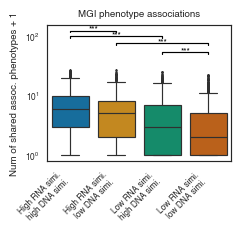

Group 0: 2820 samples
Group 1: 694 samples
Group 2: 788 samples
Group 3: 905 samples
Group 4: 689 samples
Group 5: 609 samples
Group 6: 548 samples
Group 7: 450 samples
Group 8: 369 samples
Group 9: 317 samples
Group 10: 308 samples
Group 11: 240 samples
Group 12: 183 samples
Group 13: 146 samples
Group 14: 138 samples
Group 15: 110 samples
Group 16: 85 samples
Group 17: 67 samples
Group 18: 59 samples
Group 19: 42 samples
Group 20: 27 samples
Group 21: 17 samples
Group 22: 22 samples
Group 23: 5 samples
Group 24: 6 samples
Group 25: 4 samples
Group 26: 2 samples


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


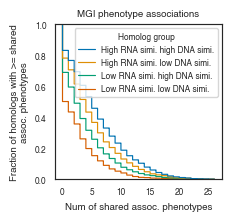

Group High RNA simi. high DNA simi.: 4097 samples
Group High RNA simi. low DNA simi.: 1201 samples
Group Low RNA simi. high DNA simi.: 1607 samples
Group Low RNA simi. low DNA simi.: 2745 samples
use specified GridSpec [0.16, 0.96, 0.9, 0.28]
unique group name: {'High RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.', 'Low RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.'}
group1 shape (1607,)
group2 shape (2745,)
Statistic: 2475845.5, P-value: 3.484711567639095e-26
p value: 3.484711567639095e-26
group1 shape (1201,)
group2 shape (2745,)
Statistic: 1993494.0, P-value: 4.292178479980473e-56
p value: 4.292178479980473e-56
group1 shape (4097,)
group2 shape (1607,)
Statistic: 3650905.0, P-value: 4.301366864234008e-15
p value: 4.301366864234008e-15
group1 shape (4097,)
group2 shape (1201,)
Statistic: 2482423.5, P-value: 0.5699507259523289
p value: 0.5699507259523289


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


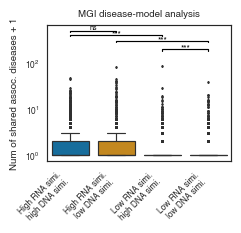

Group High RNA simi. high DNA simi.: 4097 samples
Group High RNA simi. low DNA simi.: 1201 samples
Group Low RNA simi. high DNA simi.: 1607 samples
Group Low RNA simi. low DNA simi.: 2745 samples
use specified GridSpec [0.16, 0.96, 0.9, 0.28]
unique group name: {'High RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.', 'Low RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.'}
group1 shape (1607,)
group2 shape (2745,)
Statistic: 2258788.5, P-value: 4.299418599674603e-05
p value: 4.299418599674603e-05
group1 shape (1201,)
group2 shape (2745,)
Statistic: 1720937.0, P-value: 1.439938183368782e-10
p value: 1.439938183368782e-10
group1 shape (4097,)
group2 shape (1607,)
Statistic: 3373176.5, P-value: 0.000976847260688882
p value: 0.000976847260688882
group1 shape (4097,)
group2 shape (1201,)
Statistic: 2472491.0, P-value: 0.5657177956775913
p value: 0.5657177956775913


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


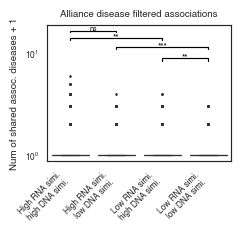

In [15]:
njson = Naming_Json()

for col in ['HMD_HumanPhenotype_num',
           'MGI_DiseaseGeneModel',
           'alliance_disease_shared_num_filt2'
           ]:
    gene_pairs_simi_anno_dna_df[f'log10_{col}'] = np.log10(gene_pairs_simi_anno_dna_df[col] + 1)
    gene_pairs_simi_anno_dna_df[f'log10_{col}'] = gene_pairs_simi_anno_dna_df[col]
    filtered_df = gene_pairs_simi_anno_dna_df[gene_pairs_simi_anno_dna_df['group'].isin([group1, group2, group3, group4])]
    num_of_asso_label = njson.num_of_shared_assoc_pheno if col == 'HMD_HumanPhenotype_num' else njson.num_of_shared_assoc_dis
    num_of_asso_label = num_of_asso_label.replace("associated", "assoc.")
    max_log_y = np.log10(max(filtered_df[col]))
    plot_comparison_box(data=filtered_df, x_var='group', y_var=col, 
                        label_column='gene_set', title=njson.get(col),
                        title_font_size=None,
                        group_pairs=[ (group3, group4), (group2, group4),  (group1, group3), (group1, group2)], 
                        min_y_value_threshold=0.1, 
                        fig_width=njson.one3rd_fig_width, fig_height=njson.fig_height_a0,
                        output_file=f"{config.proj_path}//results/figures_tables/pheno/DNA_RNA_simi.{col}.boxplot.pdf", constant_y=False, 
                        xlab='', #njson.homolog_group, 
                        GridSpec=[0.16, 0.96, 0.9, 0.28],  #left, right, top, buttom
                        ylab=f"{num_of_asso_label} + 1",
                        x_order=None, log_scale_y=True, 
                        rotate_xticklabels=True,
                        xticklabels_max_len_for_wrapping=15,
                        ylab_max_len_for_wrapping=100,
                        horizontal_line_y_pos=0.98,
                        vertical_line_len=0.2,
                        star_y_pos=0.98-max_log_y*0.07,
                        ns_y_pos=0.98+max_log_y*0.1,
                        automaticaly_add_one_minus_one_for_y_log_scale=True,
                        desired_y_tick_labels=[0, 5, 10, 20, 30],
                        non_constant_y_offset_ratio=max_log_y*0.6,
                        use_wilcox_rank_sum_test=True
                       )
    if col == 'HMD_HumanPhenotype_num':         
        plot_custom_ecdf(
            data=filtered_df,
            x_var=f'log10_{col}',
            hue='group',
            col=col,
            fig_width=njson.one3rd_fig_width,
            fig_height=njson.fig_height_a0,
            xlim=None,
            ylim=None,
            style_config=None,
            hue_order=[group1, group2, group3, group4],
            title=njson.get(col),
            xlabel=num_of_asso_label,
            ylabel=njson.ecdf_y_lab + num_of_asso_label.replace("Num of", ""),
            legend_title=njson.homolog_group,
            output_file=f"{config.proj_path}//results/figures_tables/pheno/DNA_RNA_simi.{col}.ecdf.pdf"
        )      

In [15]:
import statsmodels.api as sm

def test_proportions_difference(group1_data, group2_data):
    # Unpack the data
    count1, nobs1, count2, nobs2 = group1_data['count'], group1_data['total'], group2_data['count'], group2_data['total']
    
    # The numbers of successes
    successes = np.array([count1, count2])
    
    # The number of trials
    nobs = np.array([nobs1, nobs2])
    
    # Perform the test
    z_stat, p_value = sm.stats.proportions_ztest(successes, nobs)
    
    # Return the result
    return z_stat, p_value

### Generate barplots for phenotype association analysis

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
('Low RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.') Z-statistic: 4.0662272884134785
('Low RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.') P-value: 4.778033818909883e-05
('High RNA simi. low DNA simi.', 'Low RNA simi. low DNA simi.') Z-statistic: 6.3981343764376195
('High RNA simi. low DNA simi.', 'Low RNA simi. low DNA simi.') P-value: 1.572868407484837e-10
('High RNA simi. high DNA simi.', 'Low RNA simi. high DNA simi.') Z-statistic: 3.3079847592678977
('High RNA simi. high DNA simi.', 'Low RNA simi. high DNA simi.') P-value: 0.0009396992340901925
('High RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.') Z-statistic: 0.553209120613786
('High RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.') P-value: 0.5801202223038516
Group High RNA simi. high DNA simi.: 1 samples
Group High RNA simi. low DNA simi.: 1 samples
Group Low RNA simi. high DNA simi.: 1 samples
Group 

/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/src_mouse/eval_m/m_visual_utils.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([label.get_text().replace('_', ' ') for label in plot.get_yticklabels()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


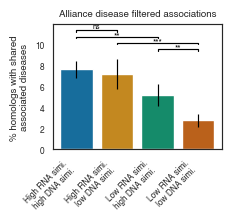

('Low RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.') Z-statistic: -12.105938827106822
('Low RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.') P-value: 9.823892680516555e-34
('High RNA simi. low DNA simi.', 'Low RNA simi. low DNA simi.') Z-statistic: -16.468925203750437
('High RNA simi. low DNA simi.', 'Low RNA simi. low DNA simi.') P-value: 6.135071701437844e-61
('High RNA simi. high DNA simi.', 'Low RNA simi. high DNA simi.') Z-statistic: -11.885205993924352
('High RNA simi. high DNA simi.', 'Low RNA simi. high DNA simi.') P-value: 1.412863242605441e-32
('High RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.') Z-statistic: -3.9478870478731984
('High RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.') P-value: 7.884398569063566e-05
Group High RNA simi. high DNA simi.: 1 samples
Group High RNA simi. low DNA simi.: 1 samples
Group Low RNA simi. high DNA simi.: 1 samples
Group Low RNA simi. low DNA simi.: 1 samples
unique group name: {'High RNA simi. high

/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/src_mouse/eval_m/m_visual_utils.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([label.get_text().replace('_', ' ') for label in plot.get_yticklabels()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


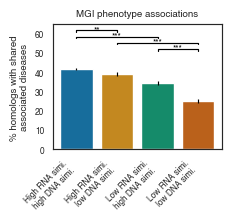

('Low RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.') Z-statistic: -10.807041471872378
('Low RNA simi. high DNA simi.', 'Low RNA simi. low DNA simi.') P-value: 3.1878583210902357e-27
('High RNA simi. low DNA simi.', 'Low RNA simi. low DNA simi.') Z-statistic: -15.50054231517533
('High RNA simi. low DNA simi.', 'Low RNA simi. low DNA simi.') P-value: 3.439764564396896e-54
('High RNA simi. high DNA simi.', 'Low RNA simi. high DNA simi.') Z-statistic: -7.413002648870883
('High RNA simi. high DNA simi.', 'Low RNA simi. high DNA simi.') P-value: 1.2347141907705927e-13
('High RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.') Z-statistic: -1.3624117447358433
('High RNA simi. high DNA simi.', 'High RNA simi. low DNA simi.') P-value: 0.1730679792848172
Group High RNA simi. high DNA simi.: 1 samples
Group High RNA simi. low DNA simi.: 1 samples
Group Low RNA simi. high DNA simi.: 1 samples
Group Low RNA simi. low DNA simi.: 1 samples
unique group name: {'High RNA simi. high DN

/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/src_mouse/eval_m/m_visual_utils.py:606: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([label.get_text().replace('_', ' ') for label in plot.get_yticklabels()])
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


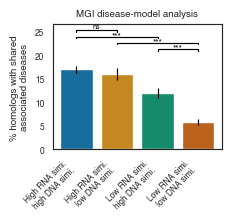

In [16]:
njson = Naming_Json()
# 'MGI_DO' stat is the same as 'alliance_disease_filt2' stat!
gene_pairs_simi_anno_dna_df['MGI_DiseaseGeneModel_shared'] = gene_pairs_simi_anno_dna_df['MGI_DiseaseGeneModel'] > 0
for col_name in ['alliance_disease_filt2', 'HMD_HumanPhenotype_bool', 'MGI_DiseaseGeneModel_shared']:
    # Create the count plot
    filtered_df = gene_pairs_simi_anno_dna_df[gene_pairs_simi_anno_dna_df['group'].isin([group1, group2, group3, group4])]
    
    counts = filtered_df.groupby(['group', col_name]).size().reset_index(name='count')
    
    # Step 2: Get total counts for each group
    total_counts = filtered_df.groupby('group').size().reset_index(name='total')
    
    # Step 3: Merge the counts with total counts
    merged = pd.merge(counts, total_counts, on='group')
    
    # Step 4: Calculate proportion
    merged['proportion'] = merged['count'] / merged['total']
    
    merged['SE'] = np.sqrt(merged['proportion'] * (1 - merged['proportion']) / merged['total'])
    merged['CI'] = 1.96 * merged['SE']  # 95% CI

    group_pairs=[ (group3, group4), (group2, group4),  (group1, group3), (group1, group2)]
    pvals = []
    for group_pair in group_pairs:
        # Example of usage:
        group1_data = merged[merged['group'] == group_pair[0]].iloc[0]
        group2_data = merged[merged['group'] == group_pair[1]].iloc[0]
        
        z_stat, p_value = test_proportions_difference(group1_data, group2_data)
        print(f'{group_pair} Z-statistic: {z_stat}')
        print(f'{group_pair} P-value: {p_value}')
        pvals.append(p_value)

    filtered_merged = merged[(merged[col_name]=="BothIntersect") | (merged[col_name]==True)]
    # Step 5: Plot the proportions
    filtered_merged.loc[:, 'proportion'] *= 100
    filtered_merged.loc[:, 'CI'] *= 100
    filtered_merged.loc[:, 'SE'] *= 100
    
    plot_comparison_bar_with_ci(df_input=filtered_merged, 
                        x_var='group', 
                        y_var='proportion', 
                        ylab=njson.frac_of_homologs_shared_disease,
                        hue=None,
                        add_legend=False,
                        fig_width=njson.one3rd_fig_width,
                        fig_height=njson.fig_height_a0,
                        title=njson.get(col_name),
                        group_pairs=group_pairs,
                        pvals=pvals,
                        horizontal_line_y_pos=1.15,
                        vertical_line_len=0.2,
                        star_y_pos=0.97,
                        ns_y_pos=1.03,
                        non_constant_y_offset_ratio=0.08,
                        output_file=f"{config.proj_path}//results/figures_tables/pheno/DNA_RNA_simi.{col_name}.barplot.pdf"
                       )

### Code below generate boxplots for association with DNA characteristics

In [17]:
align_columns = [
        'h_align_n', 'h_align_min',
       'h_align_max', 'h_align_mean', 'h_align_median', 'h_align_std',
       'm_align_n', 'm_align_min', 'm_align_max', 'm_align_mean',
       'm_align_median', 'm_align_std' 
]
align_columns = [
        'h_align_n', 'h_align_max', 'h_align_mean', 'h_align_std',
       'm_align_n', 'm_align_max', 'm_align_mean', 'm_align_std' 
]

other_cols = ['h_len_min', 'h_len_max', 'h_len_mean',
       'h_len_median', 'h_len_std', 'm_len_min', 'm_len_max', 'm_len_mean',
       'm_len_median', 'm_len_std', 'h_gc_mean', 'm_gc_mean']
other_cols = ['h_len_mean', 'h_len_std', 'm_len_mean', 'm_len_std', 'h_gc_mean', 'm_gc_mean']

delta_cols = []
for tag in ['align_n', 'len_max', 'len_mean', 'gc_mean']:
    gene_pairs_simi_anno_dna_df[f'delta_{tag}'] = gene_pairs_simi_anno_dna_df[f'h_{tag}'] - gene_pairs_simi_anno_dna_df[f'm_{tag}']
    delta_cols.append(f'delta_{tag}')

In [18]:
group11 = 'Other'
group12 = njson.simi_emb_homologs
group13 = njson.dist_emb_homologs
group14 = njson.random_pairs
group15 = 'Other'
def categorize_row1(row):

    # if row['gene_pair_group'] == "Closest_non-homolog" and row['mean_emb_similarity'] > 0.6 and row['simi_is_confidence']:
    #     return group11
    if row['gene_pair_group'] == "Homolog" and row['hm_simi_rank'] <= 1 and (row[align_score_col] >= align_score_thres or row[align_score_col] < align_score_thres):
        return group12
    elif row['gene_pair_group'] == "Homolog" and row['hm_simi_rank'] > rank_cutoff and (row[align_score_col] >= align_score_thres or row[align_score_col] < align_score_thres):
        return group13
    elif row['gene_pair_group'] == "Random_gene_pairs":
        return group14
    else:
        return group15
gene_pairs_simi_anno_dna_df['group1'] = gene_pairs_simi_anno_dna_df.apply(categorize_row1, axis=1)

In [19]:
njson = Naming_Json()
dna_rename_dict = {
    "h_align_max": njson.max_dna_score,
    "h_align_mean": njson.mean_dna_score,
    "h_align_n": njson.num_of_transcript_in_human,
    "m_align_n": njson.num_of_transcript_in_mouse,
    "h_gc_mean": njson.h_gc ,
    "m_gc_mean": njson.m_gc ,
    "h_len_mean": njson.mean_txn_len_in_human,
    "m_len_mean": njson.mean_txn_len_in_mouse,
    'delta_align_n': njson.diff_in_txn_num, 
    'delta_len_mean': njson.diff_in_txn_len, 
    'delta_gc_mean': njson.diff_in_gc,
}
gene_pairs_simi_anno_dna_df = gene_pairs_simi_anno_dna_df.rename(columns=dna_rename_dict)
# gene_pairs_simi_anno_dna_df.columns

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse


In [20]:
def replace_non_alphanumeric(text):
  return re.sub(r"[^\w]", "_", text)

In [21]:
# cds, cds_utr, promoter_upstream_1kb, downstream_1kb
seq_type_name_dict = {
    'cds': njson.cds,
    'promoter_upstream_1kb': njson.promoter_upstream_1kb,
    'downstream_1kb': njson.downstream_1kb,
}

Group <= 3: 20960 samples
Group > 3: 9038 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]


/jobfs/107166334.gadi-pbs/ipykernel_1884394/458541827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_for_txn_n['group'] = df_filtered_for_txn_n[njson.num_of_transcript_in_mouse].apply(lambda x: greater_group_name if x > txn_thre else less_group_name)
1 extra bytes in post.stringData array


unique group name: {'<= 3', '> 3'}
group1 shape (9038,)
group2 shape (20960,)
Statistic: 93984586.0, P-value: 0.28638012974326943
p value: 0.28638012974326943


'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


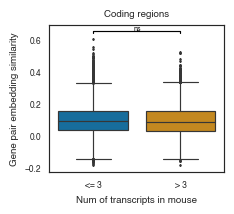

In [23]:
def test_emb_simi_vs_txn_n_random_gene_pairs():
    df_filtered_for_txn_n = gene_pairs_simi_anno_dna_df[gene_pairs_simi_anno_dna_df['gene_pair_group'] == 'Random_gene_pairs']
    
    # 2. Add an extra group based on 'Num of transcripts in mouse' > 3
    txn_thre = 3
    greater_group_name = f'> {txn_thre}'
    less_group_name = f'<= {txn_thre}'
    df_filtered_for_txn_n['group'] = df_filtered_for_txn_n[njson.num_of_transcript_in_mouse].apply(lambda x: greater_group_name if x > txn_thre else less_group_name)
    
    
    
    plot_comparison_box(data=df_filtered_for_txn_n, 
                        x_var='group', 
                        y_var='mean_emb_similarity',
                        xlab=njson.num_of_transcript_in_mouse,
                        ylab="Gene pair embedding similarity",
                        title=seq_type_name_dict[seq_type],
                        group_pairs = [(greater_group_name, less_group_name)],
                        constant_y=False,
                        fig_width=njson.get("one3rd_fig_width"), 
                        fig_height=njson.get("fig_height_a0"),
                        ylab_max_len_for_wrapping=38,
                        xticklabels_max_len_for_wrapping=15,
                        star_y_pos=0.985,
                        ns_y_pos = 1.01,
                        GridSpec=[0.18, 0.94, 0.92, 0.25],
                        output_file=f"{config.proj_path}/results/figures_tables/dna/boxplot.{seq_type}.emb_simi_vs_txn_n_random_gene_pairs.pdf",
                        use_wilcox_rank_sum_test=True
                       )
test_emb_simi_vs_txn_n_random_gene_pairs()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 17878063.5, P-value: 0.0
p value: 0.0
group1 shape (4352,)
group2 shape (27599,)
Statistic: 118819815.5, P-value: 0.0
p value: 0.0


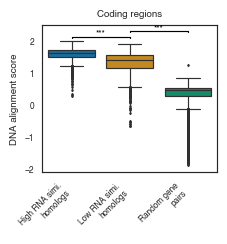

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 14203252.5, P-value: 6.70613757794661e-86
p value: 6.70613757794661e-86
group1 shape (4352,)
group2 shape (27599,)
Statistic: 109040188.0, P-value: 0.0
p value: 0.0


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


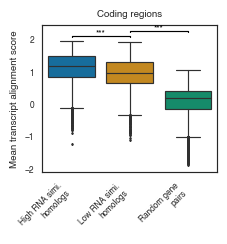

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 12930917.0, P-value: 3.912556072590944e-25
p value: 3.912556072590944e-25
group1 shape (4352,)
group2 shape (27599,)
Statistic: 57479105.5, P-value: 4.562092811382572e-06
p value: 4.562092811382572e-06


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


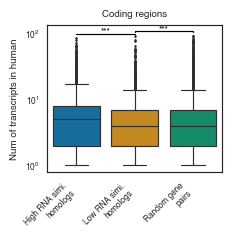

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 13136272.0, P-value: 2.6229539917480386e-33
p value: 2.6229539917480386e-33
group1 shape (4352,)
group2 shape (27599,)
Statistic: 56960366.0, P-value: 2.328051502856636e-08
p value: 2.328051502856636e-08


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


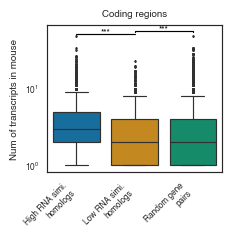

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 13094201.5, P-value: 1.3480052827814747e-30
p value: 1.3480052827814747e-30
group1 shape (4352,)
group2 shape (27599,)
Statistic: 55193777.0, P-value: 8.201151655882146e-18
p value: 8.201151655882146e-18


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


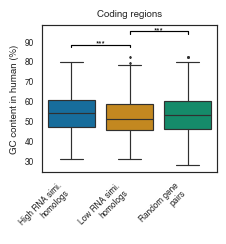

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 13871344.5, P-value: 2.431794433021483e-66
p value: 2.431794433021483e-66
group1 shape (4352,)
group2 shape (27599,)
Statistic: 52959805.5, P-value: 4.1273462034513666e-36
p value: 4.1273462034513666e-36


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


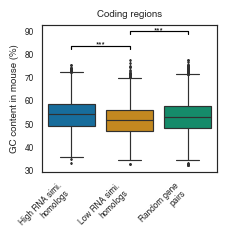

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 13155919.5, P-value: 6.387103930194765e-33
p value: 6.387103930194765e-33
group1 shape (4352,)
group2 shape (27599,)
Statistic: 56938550.5, P-value: 3.557932732051434e-08
p value: 3.557932732051434e-08


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


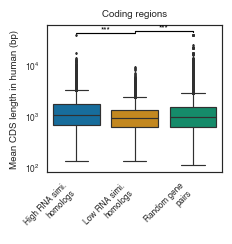

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 13129405.5, P-value: 6.526886721098583e-32
p value: 6.526886721098583e-32
group1 shape (4352,)
group2 shape (27599,)
Statistic: 57493754.5, P-value: 5.905547478692568e-06
p value: 5.905547478692568e-06


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


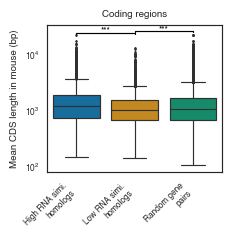

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 12044239.5, P-value: 0.00013907849021316062
p value: 0.00013907849021316062
group1 shape (4352,)
group2 shape (27599,)
Statistic: 60127152.5, P-value: 0.8987279041400754
p value: 0.8987279041400754


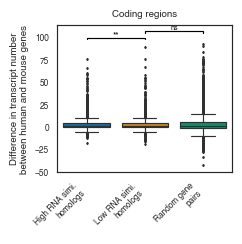

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 11383242.5, P-value: 0.2862693966463197
p value: 0.2862693966463197
group1 shape (4352,)
group2 shape (27599,)
Statistic: 58979253.5, P-value: 0.05704476984365874
p value: 0.05704476984365874


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


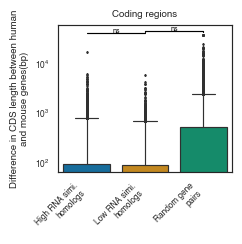

Group High RNA simi. homologs: 5298 samples
Group Low RNA simi. homologs: 4352 samples
Group Random gene pairs: 29998 samples
use specified GridSpec [0.18, 0.94, 0.92, 0.25]
unique group name: {'Low RNA simi. homologs', 'High RNA simi. homologs', 'Random gene pairs'}
group1 shape (5298,)
group2 shape (4352,)
Statistic: 10842392.0, P-value: 4.7027517680644474e-07
p value: 4.7027517680644474e-07
group1 shape (4352,)
group2 shape (27599,)
Statistic: 61276801.0, P-value: 0.030793353413599425
p value: 0.030793353413599425


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


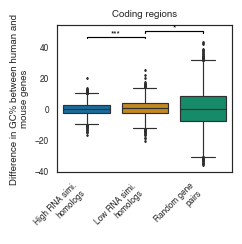

In [24]:

gene_pairs_simi_anno_dna_df_filtered = gene_pairs_simi_anno_dna_df[gene_pairs_simi_anno_dna_df['group1'].isin([group12, group13, group14])]

x_order = [njson.simi_emb_homologs, njson.dist_emb_homologs, njson.random_pairs]                    
# for col in gene_pairs_simi_anno_dna_df_filtered.columns:
for col in dna_rename_dict.values():
    #if not (col in align_columns or njson.mean_dna_score in col or njson.max_dna_score in col):
    if col not in align_columns+other_cols+delta_cols and " " not in col:
        continue
    if "1kb" in seq_type and njson.diff_in_txn_len == col:
        continue
    log_scale_y = (col == njson.num_of_transcript_in_human or col == njson.num_of_transcript_in_mouse) or ("len" in col.lower())
    col_clean = replace_non_alphanumeric(col)
    plot_comparison_box(data=gene_pairs_simi_anno_dna_df_filtered, 
                        x_var='group1', 
                        y_var=col,
                        xlab="",
                        ylab=f"{col}",
                        title=seq_type_name_dict[seq_type],
                        x_order=x_order,
                        group_pairs = [(njson.simi_emb_homologs, njson.dist_emb_homologs), (njson.dist_emb_homologs, njson.random_pairs)],
                        constant_y=False,
                        log_scale_y=log_scale_y,
                        fig_width=njson.get("one3rd_fig_width"), 
                        fig_height=njson.get("fig_height_a0"),
                        ylab_max_len_for_wrapping=38,
                        xticklabels_max_len_for_wrapping=15,
                        rotate_xticklabels=True,
                        star_y_pos=0.925 if log_scale_y else 0.978,
                        GridSpec=[0.18, 0.94, 0.92, 0.25], #left=0.25, right=0.94, top=0.9, bottom=0.15
                        output_file=f"{config.proj_path}/results/figures_tables/dna/boxplot.{seq_type}.{col_clean}.pdf",
                        use_wilcox_rank_sum_test=True
                       )
    # if col == "h_align_n":
    #     plt.yscale('log')


## Below is for human-mouse ranks vs mouse-human ranks comparisons

In [25]:
h2m_genes, m2h_genes, h2m_one2one, m2h_one2one = get_homolo_mg()
one2one_gene_pair = [f"{k} {config.gene_prefix}{v}"for k, v in h2m_one2one.items()]

In [26]:
len(m2h_one2one)

16983

In [27]:
len([(k, gene) for k, v in h2m_genes.items() for gene in v])

24601

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Column: Human ortholog rank in mouse
Number of rows with value == 1: 5147
Number of rows with value <= 10: 8956
Total number of rows: 16983
Column: Mouse ortholog rank in human
Number of rows with value == 1: 5238
Number of rows with value <= 10: 9041
Total number of rows: 16983
KS(Human ortholog rank in mouse, Mouse ortholog rank in human): stat=0.01, p=4.35e-01


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


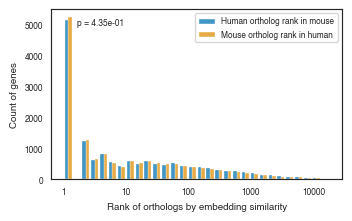

In [28]:
njson = Naming_Json()
gene_pairs_simi_anno_dna_df_one2one = gene_pairs_simi_anno_dna_df[gene_pairs_simi_anno_dna_df['gene_pair'].isin(one2one_gene_pair)]
hm_vs_mh_rank_homolog_df = gene_pairs_simi_anno_dna_df_one2one[['hm_simi_rank','mh_simi_rank']]
hm_vs_mh_rank_homolog_df = hm_vs_mh_rank_homolog_df.rename(columns={
    'hm_simi_rank': njson.hm_simi_rank,
    'mh_simi_rank': njson.mh_simi_rank
})
plot_side_by_side_histogram(hm_vs_mh_rank_homolog_df, 
                            figsize=(njson.half_fig_width, njson.fig_height_a0),
                            log_scale=True,
                            xlabel=njson.rank_of_orthologs,
                            ylabel=njson.count_of_genes,
                            output_file=f"{config.proj_path}/results/figures_tables/emb_cmp_exps/hm_vs_mh_rank_homolog.hist.pdf",
                           )

number of samples: 16983


/g/data/yr31/zs2131/venv/deep_learning/lib/python3.11/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse/src_mouse/eval_m/m_visual_utils.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, max_range], [0, max_range], 'k--', color="#505050")  # Black dashed line
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


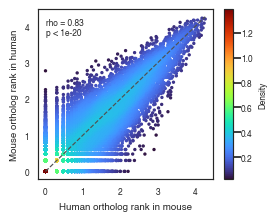

slope, intercept, r_value, p_value, std_err (0.8609205120872622, 0.1155670142287939, 0.8709016201824736, 0.0, 0.003925994502080165)


In [29]:
scatter_width_scale = 1.2
x_vals = np.log10(list(hm_vs_mh_rank_homolog_df[njson.hm_simi_rank]))
y_vals = np.log10(list(hm_vs_mh_rank_homolog_df[njson.mh_simi_rank]))
density_colored_scatter(x_vals, 
                        y_vals,
                        xlabel=njson.hm_simi_rank,
                        ylabel=njson.mh_simi_rank,
                       figsize=(njson.one3rd_fig_width*scatter_width_scale, njson.fig_height_a0),
                        output_file=f"{config.proj_path}/results/figures_tables/emb_cmp_exps/hm_vs_mh_rank_homolog.scatter.pdf",
                       )
from scipy import stats

# Remove data points with NaN
mask = ~np.isnan(x_vals) & ~np.isnan(y_vals)
x_vals_clean = x_vals[mask]
y_vals_clean = y_vals[mask]

# Perform linear regression on clean data
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals_clean, y_vals_clean)

# Print the slope
print(f'slope, intercept, r_value, p_value, std_err {(slope, intercept, r_value, p_value, std_err)}')

## Output dataframe for all the statistic

In [30]:
df_output_file = f"{config.proj_path}//results/anal/dna/stat/gene_pairs_simi_anno_dna_df.tsv"
gene_pairs_simi_anno_dna_df.to_csv(df_output_file, sep="\t", index=False)
print(f"Saved to {df_output_file}")

Saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse///results/anal/dna/stat/gene_pairs_simi_anno_dna_df.tsv


## Below is for finding significantly different phenos between gene groups

In [31]:
import pandas as pd
from itertools import chain
from collections import Counter
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests

def compare_phenotype_frequencies(df, 
                                  group1_name, 
                                  group2_name,
                                  phenotype_col='HMD_HumanPhenotype_phenos',
                                  group_col='group'
                                 ):
    # Filter data for each group
    group1_df = df[df[group_col] == group1_name]
    group2_df = df[df[group_col] == group2_name]

    # Flatten the list of phenotypes for each group
    group1_phenos = list(chain.from_iterable(group1_df[phenotype_col]))
    group2_phenos = list(chain.from_iterable(group2_df[phenotype_col]))

    # Count the occurrence of each phenotype in each group
    group1_pheno_counts = Counter(group1_phenos)
    group2_pheno_counts = Counter(group2_phenos)

    # Get all unique phenotypes across both groups
    all_phenos = set(group1_pheno_counts.keys()).union(set(group2_pheno_counts.keys()))

    # Calculate total counts for normalization
    total_count_group1 = sum(group1_pheno_counts.values())
    total_count_group2 = sum(group2_pheno_counts.values())

    # Prepare data for chi-squared test and store results
    results = []
    for pheno in all_phenos:
        count1 = group1_pheno_counts[pheno]
        count2 = group2_pheno_counts[pheno]
        ratio1 = count1 / total_count_group1 if total_count_group1 > 0 else 0
        ratio2 = count2 / total_count_group2 if total_count_group2 > 0 else 0
        contingency_table = [[count1, total_count_group1 - count1],
                             [count2, total_count_group2 - count2]]
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        results.append([pheno, count1, count2, count1 - count2, ratio1, ratio2, p])

    # Convert results to DataFrame
    result_df = pd.DataFrame(results, columns=['Phenotype', 'Count_Group1', 'Count_Group2', 'Count_Diff', 'Ratio_Group1', 'Ratio_Group2', 'P_Value'])

    # Adjust p-values for multiple testing using Bonferroni correction
    p_vals = result_df['P_Value'].values
    reject, p_vals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='bonferroni')
    
    # Add the corrected p-values to the DataFrame
    result_df['P_Value_Corrected'] = p_vals_corrected
    result_df['Significant'] = reject

    # Filter for significant results
    significant_df = result_df[result_df['Significant']]

    # Return the results
    return result_df, significant_df

result_df, significant_df = compare_phenotype_frequencies(gene_pairs_simi_anno_dna_df, 
                                                          njson.high_rna_high_dna, 
                                                          njson.low_rna_high_dna,
                                                          phenotype_col='HMD_HumanPhenotype_phenos'
                                                         )


In [32]:
def get_phenotype_id_name_mapping_df(config):
    file_path = f"{config.proj_path}/data/external/Homolo/MouseGenomeInfo/VOC_MammalianPhenotype.rpt"

    # Read the TSV file
    df = pd.read_csv(file_path, sep='\t', header=None)
    
    # Assign custom column names
    df.columns = ["Phenotype ID", "Phenotype name", "Phenotype description"]
    return df
phenotype_id_name_mapping_df = get_phenotype_id_name_mapping_df(config)

In [33]:
significant_phenos_df = pd.merge(significant_df, phenotype_id_name_mapping_df, 
                     how='left', 
                     left_on='Phenotype', 
                     right_on='Phenotype ID')
output_path = f"{config.proj_path}/results/anal/stat/significant_phenos_df.tsv"
significant_phenos_df.to_csv(output_path, sep='\t', index=False)

print(f"File saved to {output_path}")


File saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse//results/anal/stat/significant_phenos_df.tsv


## Below is for outputing tables for data availability

In [34]:
def common_process_for_df_for_export(emb_stat_df):
    emb_stat_df = emb_stat_df[emb_stat_df['mean_emb_similarity'].notna()].copy()
    emb_stat_df['hm_simi_rank'] = emb_stat_df['hm_simi_rank'].astype(int)
    emb_stat_df['mh_simi_rank'] = emb_stat_df['mh_simi_rank'].astype(int)
    emb_stat_df['m_gene'] = emb_stat_df['m_gene'].str.replace(config.gene_prefix, '')
    emb_stat_df = emb_stat_df.rename(columns={
        'h_gene': "Human gene",
        'm_gene': "Mouse gene", 
        'hm_simi_rank': njson.hm_simi_rank, 
        'mh_simi_rank': njson.mh_simi_rank, 
        'mean_emb_similarity': "Embedding similarity",
        'group': "Group"
    })
    return emb_stat_df

In [35]:
njson = Naming_Json()
selected_cols = [
                'h_gene', 
                'm_gene', 
                'mean_emb_similarity', 
                'hm_simi_rank', 
                'mh_simi_rank', 
                njson.max_dna_score,
                njson.mean_dna_score, 
                'group']
emb_stat_df = gene_pairs_simi_anno_dna_df[gene_pairs_simi_anno_dna_df['gene_pair_group']=='Homolog'][selected_cols]
emb_stat_df = common_process_for_df_for_export(emb_stat_df)


df_output_file = f"{config.proj_path}//results/anal/dna/stat/emb_stat_df.tsv"
emb_stat_df.to_csv(df_output_file, sep="\t", index=False)
print(f"Saved to {df_output_file}")

Using mouse project folder: /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse
Saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse///results/anal/dna/stat/emb_stat_df.tsv


In [36]:
if seq_type == "cds":
    legend = f"{config.proj_path}/data/meta/naming/emb_stat_df_legend.txt"
    export_to_excel({"Emb_simi_DNA_simi":emb_stat_df}, 
                    legend, 
                    f"{config.proj_path}/results/figures_tables/tables/Homologs_emb_simi_DNA_simi.xlsx",
                    capitalize_headers=False
                   )

In [37]:
col_to_exclude = [
    'gene_pair', 
    'MGI_DiseaseGeneModel_with_m_geno',
    'alliance_disease_filt1',
    'alliance_disease_shared_num_filt1',
    'alliance_disease_shared_list_filt1',
    'MGI_DO', 
    'MGI_shared_num',
    'h_align_min',
    'h_align_median', 
    'h_align_std',
    'm_align_min', 
    'm_align_max',
    'm_align_mean', 
    'm_align_median', 
    'm_align_std', 
    'h_len_min',
    'h_len_max',
    'h_len_median',
    'h_len_std', 
    'm_len_min', 
    'm_len_max',
    'm_len_median', 
    'm_len_std',
    'log10_HMD_HumanPhenotype_num', 
    'log10_MGI_DiseaseGeneModel',
    'log10_alliance_disease_shared_num_filt2',
    'delta_len_max',
    'HMD_HumanPhenotype_bool',
    'alliance_disease_full', 
    'alliance_disease_filt2',
    'MGI_DiseaseGeneModel_shared',
    'group1'
]


selected_cols = [col for col in gene_pairs_simi_anno_dna_df.columns if col not in col_to_exclude]
all_stat_for_output_df = gene_pairs_simi_anno_dna_df[(gene_pairs_simi_anno_dna_df['gene_pair_group']=='Homolog')| (gene_pairs_simi_anno_dna_df['gene_pair_group']=='Random_gene_pairs')][selected_cols]
all_stat_for_output_df = common_process_for_df_for_export(all_stat_for_output_df)
for list_col in ["HMD_HumanPhenotype_phenos", "MGI_DiseaseGeneModel_diseases", "alliance_disease_shared_list_full", "alliance_disease_shared_list_filt2"]:
    all_stat_for_output_df[list_col] = all_stat_for_output_df[list_col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
rename_dict = {
    'gene_pair_group': "Gene pair group",
    'HMD_HumanPhenotype_num':f"{njson.num_of_shared_assoc_pheno} in {njson.HMD_HumanPhenotype_num}",
    'HMD_HumanPhenotype_phenos':f"{njson.num_of_shared_assoc_pheno.replace('Num', 'List')} in {njson.HMD_HumanPhenotype_num}",
    'MGI_DiseaseGeneModel': f"{njson.num_of_shared_assoc_dis} in {njson.MGI_DiseaseGeneModel}", 
    'MGI_DiseaseGeneModel_diseases': f"{njson.num_of_shared_assoc_dis.replace('Num', 'List')} in {njson.MGI_DiseaseGeneModel}", 
    'alliance_disease_shared_num_full':f"{njson.num_of_shared_assoc_dis} in {njson.alliance_disease_full}",
    'alliance_disease_shared_list_full':f"{njson.num_of_shared_assoc_dis.replace('Num', 'List')} in {njson.alliance_disease_full}",
    'alliance_disease_shared_num_filt2': f"{njson.num_of_shared_assoc_dis} in {njson.alliance_disease_filt2}",
    'alliance_disease_shared_list_filt2': f"{njson.num_of_shared_assoc_dis.replace('Num', 'List')} in {njson.alliance_disease_filt2}", 
    'emb_simi_sup_align': f"Emb. simi. from {njson.supervised}",
    'emb_simi_shared_emb_plus_sup_align': f"Emb. simi. from {njson.anchor} + {njson.supervised}",
}
all_stat_for_output_df = all_stat_for_output_df.rename(columns=rename_dict)
df_output_file = f"{config.proj_path}//results/anal/dna/stat/all_stat_for_output_df.{seq_type}.tsv"
if seq_type != "cds":
    cols_for_non_cds = ['Human gene', 
                        'Mouse gene',
                        'GC content in human (%)', 
                        'GC content in mouse (%)',
                        'DNA alignment score',
                        'Mean transcript alignment score'
                       ]
    all_stat_for_output_df = all_stat_for_output_df[cols_for_non_cds]
all_stat_for_output_df.to_csv(df_output_file, sep="\t", index=False)
print(f"Saved to {df_output_file}")
if seq_type == "cds":
    legend = f"{config.proj_path}/data/meta/naming/all_stat_for_output_df_legend.txt"
    export_to_excel({"Stat":all_stat_for_output_df}, 
                    legend, 
                    f"{config.proj_path}/results/figures_tables/tables/emb_simi_DNA_pheno_coding_genes.{seq_type}.xlsx",
                    capitalize_headers=False
                   )
else:
    legend = f"{config.proj_path}/data/meta/naming/all_stat_for_output_df_legend.{seq_type}.txt"
    export_to_excel({"Stat":all_stat_for_output_df}, 
                    legend, 
                    f"{config.proj_path}/results/figures_tables/tables/DNA_stat_coding_genes.{seq_type}.xlsx",
                    capitalize_headers=False
                   )

Saved to /g/data/yr31/zs2131/tasks/2023/RNA_expr_net/GeneRAIN_Mouse///results/anal/dna/stat/all_stat_for_output_df.cds.tsv


In [38]:
# import glob
# from data_m.get_homolo_mg import get_homolo_mg
# def get_combined_dna_seq_conserv_df(seq_type, config):
#     def read_dna_seq_of_gene_pairs_conserv_results(seq_type, gene_list_name, total_num_of_chunks, config):
#         output_file_prefix = f"{config.proj_path}/results/anal/dna/dna_seq_of_gene_pairs/{gene_list_name}"
#         tsv_files = glob.glob(f"{output_file_prefix}.{seq_type}.*_of_{total_num_of_chunks}.tsv")
#         if len(tsv_files) != total_num_of_chunks:
#             print(f"Only {len(tsv_files)} of {total_num_of_chunks} files found!")
        
#         dataframes = [pd.read_csv(file, sep='\t') for file in tsv_files]
#         combined_df = pd.concat(dataframes)
#         return combined_df
#     h2m_genes, m2h_genes, h2m_one2one, m2h_one2one = get_homolo_mg()
#     all_homolog_gene_pairs_human_on_left = [f"{k} {config.gene_prefix}{gene}" for k, v in h2m_genes.items() for gene in v]
    
    
#     # seq_type = "promoter_upstream_1kb" # cds, cds_utr, promoter_upstream_1kb, downstream_1kb
    
#     gene_list_name = "output_h2m_genes"
#     total_num_of_chunks = 50
#     dna_cons_df = read_dna_seq_of_gene_pairs_conserv_results(seq_type, gene_list_name, total_num_of_chunks, config)
    
#     gene_list_name = "exp16_hm_BERT_coding.epoch20.full_spv_1st"
#     total_num_of_chunks = 100
#     conserv_for_non_homolog_closest_emb_gene_pair_df = read_dna_seq_of_gene_pairs_conserv_results(seq_type, gene_list_name, total_num_of_chunks, config)
    
#     gene_list_name = "random_gene_pairs_exp16_seed8"
#     total_num_of_chunks = 100
#     random_gene_pairs_cons_df = read_dna_seq_of_gene_pairs_conserv_results(seq_type, gene_list_name, total_num_of_chunks, config)                                                                                            
    
#     gene_list_name = "ave_supAlign_and_sharedEmbSupAlign"
#     total_num_of_chunks = 100
#     dna_ave_df = read_dna_seq_of_gene_pairs_conserv_results(seq_type, gene_list_name, total_num_of_chunks, config)  

#     # dna_cons_df["gene_pair_group"] = "one2one_homolog"
#     # conserv_for_non_homolog_closest_emb_gene_pair_df["gene_pair_group"] = "non_homolog_closest_emb"
#     # random_gene_pairs_cons_df["gene_pair_group"] = "random_gene_pairs"
    
#     conserv_for_non_homolog_closest_emb_gene_pair_df = conserv_for_non_homolog_closest_emb_gene_pair_df[
#         ~conserv_for_non_homolog_closest_emb_gene_pair_df['gene_pair'].isin(all_homolog_gene_pairs_human_on_left)
#     ]
#     dna_cons_df_combined = pd.concat([dna_cons_df, conserv_for_non_homolog_closest_emb_gene_pair_df, random_gene_pairs_cons_df, dna_ave_df])
#     # dna_cons_df_combined[['h_gene', 'm_gene']] = dna_cons_df_combined['gene_pair'].str.split(' ', expand=True)
#     return dna_cons_df_combined.drop_duplicates()

# def combine_similarity_stat_with_dna_and_anno_info(simi_mat, gene_names, seq_type, config, njson):
#     dna_cons_df_combined = get_combined_dna_seq_conserv_df(seq_type=seq_type, config=config)
#     return get_simi_and_anno_for_df(dna_cons_df_combined, simi_mat, gene_names, config, njson)

# cds, cds_utr, promoter_upstream_1kb, downstream_1kb
# dna_cons_df_combined_expanded = combine_similarity_stat_with_dna_and_anno_info(simi_mat=averaged_align_and_shared_emb_align_simi_mat, 
#                                                                                gene_names=hm_gene_names, 
#                                                                                seq_type="cds", 
#                                                                                config=config, 
#                                                                                njson=njson)

In [77]:

    # plt.figure(figsize=(12, 8))
    # sns.kdeplot(data=filtered_df, x=f'log10_{col}', hue='group', fill=True)
    # plt.title(f"Comparing log10 Transformed {col} Among Groups")
    # plt.show()


    # plt.figure(figsize=(12, 8))
    # sns.histplot(data=filtered_df, x=f'log10_{col}', hue='group', multiple="dodge", bins=10)
    # plt.title(f"Comparing log10 Transformed {col} Among Groups")
    # plt.show()
               
    # Create the boxplot using the new transformed column
    # plt.figure(figsize=(5, 5))
    # sns.boxplot(x='group', y=f'log10_{col}', data=filtered_df)
    # plt.title(f"Comparing log10 Transformed {col} Among Groups")
    # plt.show()
               
    # plt.figure(figsize=(12, 8))
    # sns.stripplot(data=gene_pairs_simi_anno_dna_df, x='group', y=f'log10_{col}', jitter=True)
    # plt.title(f"Scatter Plot with Jitter for log10 Transformed {col} Among Groups")
    # plt.show()
    
    # Bee Swarm Plot
    # plt.figure(figsize=(12, 8))
    # sns.swarmplot(data=gene_pairs_simi_anno_dna_df, x='group', y=f'log10_{col}')
    # plt.title(f"Bee Swarm Plot for log10 Transformed {col} Among Groups")
    # plt.show()
    
    
    # Dot Plot
    # plt.figure(figsize=(12, 8))
    # sns.pointplot(data=gene_pairs_simi_anno_dna_df, x='group', y=f'log10_{col}', join=False, capsize=0.1)
    # plt.title(f"Dot Plot for log10 Transformed {col} Among Groups")
    # plt.show()
    
    # Cumulative Distribution Plot (CDF)
    # plt.figure(figsize=(5, 5))
    # sns.ecdfplot(data=gene_pairs_simi_anno_dna_df, x=f'log10_{col}', hue='group', complementary=True)
    # plt.title(f"CDF for log10 Transformed {col} Among Groups")
    # plt.show()

    
    # # Bar Plot with Error Bars
    # plt.figure(figsize=(12, 8))
    # sns.barplot(data=gene_pairs_simi_anno_dna_df, x='group', y=f'log10_{col}', ci='sd')
    # plt.title(f"Bar Plot with Error Bars for log10 Transformed {col} Among Groups")
    # plt.show()
    
    # # Boxen Plot (Letter-Value Plot)
    # plt.figure(figsize=(12, 8))
    # sns.boxenplot(data=gene_pairs_simi_anno_dna_df, x='group', y=f'log10_{col}')
    # plt.title(f"Boxen Plot for log10 Transformed {col} Among Groups")
    # plt.show()

In [78]:
# # gene_pairs_simi_anno_dna_df['mean_emb_similarity'] = gene_pairs_simi_anno_dna_df['emb_similarity']

# confident_simi_ratio_thres = 1.2
# gene_pairs_simi_anno_dna_df['simi_is_confidence'] = gene_pairs_simi_anno_dna_df.apply(
#     lambda row: abs(row['emb_simi_sup_align'] - row['emb_simi_shared_emb_plus_sup_align']) < 0.1 
#                 or (1/confident_simi_ratio_thres < row['emb_simi_sup_align'] / row['emb_simi_shared_emb_plus_sup_align'] < confident_simi_ratio_thres), 
#     axis=1
# )
# simi_confidence_counts = Counter(gene_pairs_simi_anno_dna_df['simi_is_confidence'])

# print(simi_confidence_counts.items())


# plt.figure(figsize=(10, 10))
# plt.scatter(x='emb_simi_sup_align', y='emb_simi_shared_emb_plus_sup_align', c='simi_is_confidence', data=gene_pairs_simi_anno_dna_df)
# plt.title("Scatter Plot with Two Groups")
# plt.xlabel("Values1")
# plt.ylabel("Values2")
# plt.grid(True)
# plt.show()

In [ ]:
# group1 = 'Group 1: non_homolog_closest_emb'
# group2 = 'Group 2: one2one_homolog ==1'
# group3 = 'Group 3: one2one_homolog > {rank_cutoff}'
# group4 = 'Group 4: random_gene_pairs'
# group5 = 'Other'
# def categorize_row1(row):

#     if row['gene_pair_group'] == "Closest_non-homolog" and row['mean_emb_similarity'] > 0.6 and row['simi_is_confidence']:
#         return group1
#     elif row['gene_pair_group'] == "Homolog" and row['hm_simi_rank'] <= 1 and row['simi_is_confidence']:
#         return group2
#     elif row['gene_pair_group'] == "Homolog" and row['hm_simi_rank'] > rank_cutoff and row['simi_is_confidence']:
#         return group3
#     elif row['gene_pair_group'] == "Random_gene_pairs" and row['simi_is_confidence']:
#         return group4
#     else:
#         return group5

In [ ]:
    # plt.figure(figsize=(5, 5))
    # ax = sns.countplot(data=filtered_df, x='group', hue=col_name)
    # plt.title(f'Distribution of {col_name} Categories Across Groups')
    # plt.xlabel('Group')
    # plt.ylabel('Frequency')
    # plt.legend(title=col_name)
    # plt.xticks(rotation=45)
    
    
    # plt.tight_layout()
    # plt.show()